## Full Repo
https://github.com/MostafaBelo/Konecta_Assignments/tree/main

## Imports

In [ ]:
!pip install -r requirements.txt

In [1]:
import getpass
import os
import sys
from dotenv import load_dotenv

import uuid
import json
import hashlib

from langchain_google_genai import ChatGoogleGenerativeAI

from langchain.schema import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

import chromadb
from chromadb.utils import embedding_functions

import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, RemoveMessage

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

from tqdm import tqdm

In [2]:
# Load .env file
load_dotenv()

env_keys = [
    "GOOGLE_API_KEY",
]
for key in env_keys:
    if not os.environ.get(key):
        os.environ[key] = getpass.getpass(f"Enter API key for {key}: ")

## Utils

In [ ]:
# Gemini Model
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None, # Max output tokens
    timeout=None,
    max_retries=2,
    google_api_key=os.environ.get("GOOGLE_API_KEY") # Replace with API key from https://aistudio.google.com/apikey
)

In [ ]:
# Embedings Model
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

## Vector Store - ChromaDB

In [5]:
chroma_client = chromadb.PersistentClient(path="./db")

In [6]:
collection = chroma_client.get_or_create_collection(
    name="konecta_assignment_6",
    metadata={
        "loaded_documents": "[]",
    },
    embedding_function=sentence_transformer_ef
)

In [7]:
collection.count()

371

## Manuals Loading

In [8]:
pdf_paths = [os.path.join("manuals", pdf_path) for pdf_path  in os.listdir("manuals")]
loaded_documents: list[str] = json.loads(collection.metadata["loaded_documents"])

docs: list[Document] = []

# Chunker
recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800, chunk_overlap=120, separators=["\n\n", "\n", " ", ""]
)

# metadata extractors
def getId(metadata: str, text: str) -> str:
            return hashlib.sha256(f"{metadata} | {text}".encode("utf-8")).hexdigest()
def getMetaData(full_metadata: dict[str, any]):
    res = {
        "document_name": "",
        "page_number": -1,
        "section_heading": "",
    }

    if "source" in full_metadata:
        res["document_name"] = full_metadata["source"]
    if "page" in full_metadata:
        res["page_number"] = full_metadata["page"]

    for key in res.keys():
        if key in full_metadata:
            res[key] = full_metadata[key]
    
    return res

# Documents loading and storing
for pdf_path in tqdm(pdf_paths, desc="PDF Documents"):
    if pdf_path not in loaded_documents:
        loader = PyPDFLoader(pdf_path)
        docs = loader.load()  # one Document per page

        docs = [c for c in docs if c.page_content != ""]

        recursive_chunks = recursive_splitter.split_documents(docs)

        recursive_chunks = [c for c in recursive_chunks if c.page_content != ""]

        collection.add(
            ids=[getId(str(c.metadata), c.page_content) for c in recursive_chunks],
            metadatas=[getMetaData(c.metadata) for c in recursive_chunks],
            documents=[c.page_content for c in recursive_chunks],
        )

        loaded_documents.append(pdf_path)
        collection.modify(metadata={
             "loaded_documents": json.dumps(loaded_documents)
        })

PDF Documents: 100%|██████████| 4/4 [00:00<00:00, 45590.26it/s]


In [9]:
collection.count()

371

## Chat Bot with Memory

In [10]:
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

os.makedirs("state_db", exist_ok=True)
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

memory = SqliteSaver(conn)

In [11]:
system_message = """
You are a helpful assistant that has access to a few manuals.
Answer questions based on previous chat history and the content within the manual snippets provided to you in the prompts.
If the question of the user concerns content not covered by previous chat history, not by the manuals and not in the snippets of context retrerived, respond accordingly to the user stating that you don't have the answer.
Make sure to cite all your responses from the manuals' metadata. The metadata will include the manual's file name and the page from which the snippet is extracted.
"""

rag_system_template = """
Use the following manual snippets, any previously provided ones, and previous chat history, as context to respond to the following user query. Not all snippets may be relevant.
Answer questions based on previous chat history and the content within the manual snippets provided to you in the prompts.
If the question of the user concerns content not covered by previous chat history, not by the manuals and not in the snippets of context retrerived, respond accordingly to the user stating that you don't have the answer.
Make sure to cite all your responses from the manuals' metadata. The metadata will include the manual's file name and the page from which the snippet is extracted.
Also keep in mind the previous chat history in case of follow up questions.

{context}
"""

def rag_node(state: MessagesState):
    global rag_system_template

    if len(state["messages"]) < 1:
        # raise Exception("No Prompt to RAG")
        return {}
    
    last_message = state["messages"][-1]
    if not isinstance(last_message, HumanMessage):
        # raise Exception("No Prompt to RAG")
        return {}
    
    document_names: list[str] = json.loads(collection.metadata["loaded_documents"])

    combined_results = {
        "documents": [],
        "metadatas": []
    }

    for document_name in document_names:
        results = collection.query(
            query_texts=[last_message.content],
            n_results=5,
            where={
                "document_name": document_name
            }
        )

        combined_results["documents"] += results["documents"][0]
        combined_results["metadatas"] += results["metadatas"][0]

    context_content = "\n\n".join([f"Metadata: {meta}\nContent: {doc}" for doc, meta in zip(combined_results["documents"], combined_results["metadatas"])])

    context_message = rag_system_template.format(context=context_content)

    return {
        "messages": [
            RemoveMessage(id=last_message.id),
            SystemMessage(content=context_message),
            HumanMessage(content=last_message.content),
        ]
    }

def call_model_node(state: MessagesState):
    messages = [SystemMessage(content=system_message)] + state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

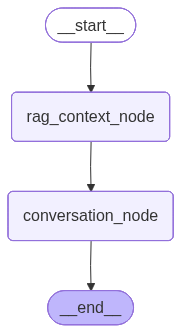

In [12]:
# Define a new graph
workflow = StateGraph(MessagesState)
workflow.add_node("rag_context_node", rag_node)
workflow.add_node("conversation_node", call_model_node)

# Set the entrypoint as conversation
workflow.add_edge(START, "rag_context_node")
workflow.add_edge("rag_context_node", "conversation_node")
workflow.add_edge("conversation_node", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
class ChatThread:
    def __init__(self, thread_id: str | None = None):
        if thread_id is None:
            self.thread_id = str(uuid.uuid4())
        else:
            self.thread_id = thread_id
        self.config = {"configurable": {"thread_id": self.thread_id}}

        self.state: MessagesState = {
            "messages": []
        }

    def invoke(self, prompts: str | list[str]):
        if not isinstance(prompts, list):
            prompts = [prompts]

        for prompt in prompts:
            input_message = HumanMessage(content=prompt)
            output = graph.invoke({"messages": [input_message]}, self.config)

        self.state = output

    def print_history(self, show_system=False):
        for m in self.state["messages"]:
            if isinstance(m, SystemMessage) and not(show_system):
                continue
            m.pretty_print()

In [14]:
chat = ChatThread()

prompts = [
    "what are the different laptop serires covered by the manuals?",
    "what ram does each laptop series in any of the manuals have?",
]
chat.invoke(prompts)

chat.print_history()

================================ Human Message =================================

what are the different laptop serires covered by the manuals?
================================== Ai Message ==================================

The manuals cover the following laptop series:

*   **GIGABYTE G6** (manuals/g6_mf.pdf, page 0)
*   **Lenovo IdeaPad L340 Series** (manuals/ideapad_l340_series.pdf, page 4)
*   **Lenovo LOQ Series** (specifically models 15AHP9, 15ARP9, 15IAX9, 15IAX9I, and 15IRX9) (manuals/loq_15ahp9.pdf, page 0)
*   **ASUS TUF Gaming F17 (FX707Z) series** (manuals/tuf_gaming_f17_series.pdf, page 3, 5)
================================ Human Message =================================

what ram does each laptop series in any of the manuals have?
================================== Ai Message ==================================

Based on the provided manuals, here is the RAM information for each laptop series:

*   **GIGABYTE G6:** The specific type or capacity of RAM is not detailed in

In [15]:
chat = ChatThread()

prompts = [
    "How do phones work?",
]
chat.invoke(prompts)

chat.print_history()

================================ Human Message =================================

How do phones work?
================================== Ai Message ==================================

I apologize, but the provided manuals do not contain information on how phones work. The manuals focus on the features and components of GIGABYTE, Lenovo IdeaPad, Lenovo LOQ, and ASUS TUF Gaming laptops.


In [ ]:
chat = ChatThread()

prompts = [
    "what are the hotkeys and their functions of Gigabyte G6?",
    "Which of them would I use to put the laptop to sleep?",
]
chat.invoke(prompts)

chat.print_history()

================================ Human Message =================================

what are the hotkeys and their functions of Gigabyte G6?
================================== Ai Message ==================================

The Gigabyte G6 computer employs hotkeys, which are key combinations used to access various controls. To activate these hotkeys, you need to press and hold the `<Fn>` key before pressing the other key in the combination.

Here are the hotkeys and their functions:

*   **Fn + ~**: Play / Pause (in Audio/Video Programs)
*   **Fn + F1**: Touchpad Toggle
*   **Fn + F2**: Turn LCD Backlight OFF (Press a key or use Touchpad to turn on)
*   **Fn + F3**: Mute Toggle
*   **Fn + F5/F6**: Volume Decrease/Increase
*   **Fn + F7**: Display Toggle
*   **Fn + F8/F9**: Brightness Decrease/Increase
*   **Fn + F10**: PC Camera Power on and Off
*   **Fn + F11**: Airplane Mode Toggle
*   **Fn + F12**: Sleep Toggle
*   **NumLK**: Number Lock Toggle
*   **Fn + ScrLK**: Scroll Lock Toggle
* 

In [ ]:
chat = ChatThread()

prompts = [
    "Which of the laptops has the best help and support post-purchase?",
    "Which of the laptops is objectively the most capable specs wise?",
    "In your opinion, which of the laptops would be the besst balance between customer support and specs?",
]
chat.invoke(prompts)

chat.print_history()

================================ Human Message =================================

Which of the laptops has the best help and support post-purchase?
================================== Ai Message ==================================

Based on the provided manual snippets, the **Lenovo LOQ series** appears to offer the most comprehensive help and support post-purchase, as it explicitly states that additional services can be purchased both during and after the warranty period (manuals/loq_15ahp9.pdf, page 40).

Here's a breakdown of the support mentioned for each:

*   **Lenovo LOQ 15AHP9, 15ARP9, 15IAX9, 15IAX9I, and 15IRX9:**
    *   Offers services during the warranty period including problem determination, Lenovo hardware repair, and engineering change management (manuals/loq_15ahp9.pdf, page 39).
    *   Crucially, you can **purchase additional services during and after the warranty period** (manuals/loq_15ahp9.pdf, page 40).

*   **Lenovo IdeaPad L340 Series:**
    *   Provides "Lenovo

In [19]:
chat = ChatThread()

prompts = [
    "How is each laptop's battery-life?",
]
chat.invoke(prompts)

chat.print_history()

================================ Human Message =================================

How is each laptop's battery-life?
================================== Ai Message ==================================

I apologize, but the provided manual snippets do not contain information regarding the specific battery life (how long the battery lasts on a single charge) for any of the laptops.

However, the manuals do provide details on battery charging times and management:

*   **Lenovo IdeaPad L340 Series:** The battery is fully charged in approximately four to eight hours. If the power adapter supports rapid charge, the battery can reach 80% charge in about 1 hour when the computer is turned off. The recommended temperature range for charging is between 10°C (50°F) and 35°C (95°F). The computer will not start recharging if the remaining power is greater than 95% to maximize battery life (manuals/ideapad_l340_series.pdf, page 26).
*   **Lenovo LOQ 15ahp9:** In normal charging mode, it typically take